In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline

Welcome to JupyROOT 6.12/06


In [35]:
f = r.TFile("./data/gm2offline_ana.root")
twest = f.Get("farline").Get("eventTree")
teast = f.Get("farline").Get("eastTree")
tcomp = f.Get("farline").Get("evwTree")
terr = f.Get("farline").Get("evwNoPartnerTree")

tcomp2 = f.Get("farline").Get("wveTree")
terr2 = f.Get("farline").Get("wveNoPartnerTree")

fwave = r.TFile("./data/waveforms.root")
twave = fwave.Get("islands").Get("islands").Get("islandTree")

In [36]:
teast.Print()

******************************************************************************
*Tree    :eastTree  : eastTree                                               *
*Entries :   270321 : Total =        64189330 bytes  File  Size =   22461437 *
*        :          : Tree compression factor =   2.86                       *
******************************************************************************
*Br    0 :runNum    : runNum/i                                               *
*Entries :   270321 : Total  Size=    1084891 bytes  File Size  =       9161 *
*Baskets :       34 : Basket Size=      32000 bytes  Compression= 118.32     *
*............................................................................*
*Br    1 :subRunNum : subRunNum/i                                            *
*Entries :   270321 : Total  Size=    1085005 bytes  File Size  =       9229 *
*Baskets :       34 : Basket Size=      32000 bytes  Compression= 117.46     *
*...................................................

In [4]:
twest.Print()

******************************************************************************
*Tree    :eventTree : eventTree                                              *
*Entries :   364619 : Total =        44823592 bytes  File  Size =   14560502 *
*        :          : Tree compression factor =   3.08                       *
******************************************************************************
*Br    0 :runNum    : runNum/i                                               *
*Entries :   364619 : Total  Size=    1463293 bytes  File Size  =      12419 *
*Baskets :       46 : Basket Size=      32000 bytes  Compression= 117.73     *
*............................................................................*
*Br    1 :subRunNum : subRunNum/i                                            *
*Entries :   364619 : Total  Size=    1463443 bytes  File Size  =      12512 *
*Baskets :       46 : Basket Size=      32000 bytes  Compression= 116.86     *
*...................................................

In [42]:
def constructUniqueID( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fill).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandEast).zfill(5)) 
    return uniqueID
def constructUniqueIDwest( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.eventNum).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandWest).zfill(5)) 
    return uniqueID
def constructUniqueIDeast( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fillIndex).zfill(5) +
                            str(entry.calorimeterIndex).zfill(5) + str(entry.islandIndex).zfill(5)) 
    return uniqueID
def constructUniqueIDwave( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fillNum).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandNum).zfill(5)) 
    return uniqueID

In [78]:
def ReturnNeighbors_4(x, y):
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            if (((i, j) != (x, y)) and i < 9 and j < 6 and i > -1 and j > -1):
                yield (int(i), int(j))

In [6]:
def toMap( crystalsInCluster ):
    xtalMapEast = []
    for i in range(54):
        if(i in crystalsInCluster):
            xtalMapEast.append(1)
        else:
            xtalMapEast.append(0)

    xtalMapEast.reverse()
    list1 = []
    list2 = []
    xtal = []
    list2xtal = []
    for crystal in range(54):
        list2.append(xtalMapEast[crystal]) 
        list2xtal.append(crystal)
        if (crystal+1) % 9 == 0: #split into 9 column blocks
            list1.append(list2)
            list2 = []
            list2xtal.reverse()
            xtal.append(list2xtal)
            list2xtal = []
    xtal.reverse()
    
    return( list1 )

def arrangeXtals( vec1 ):
    vec1.reverse()
    list1 = []
    list2 = []
    for crystal in range(54):
        list2.append(vec1[crystal]) 
        if (crystal+1) % 9 == 0: #split into 9 column blocks
            list1.append(list2)
            list2 = []
            list2xtal = []
    return(list1)

def imshowCompare(vec1, vec2, showPlot = True, titleString = ''):
    vec3 = []
    for i in range(len(vec1)):
        vec3i = []
        for j in range(len(vec1[0])):
            if(vec1[i][j] > 0.1 and vec2[i][j] > 0.1):
                vec3i.append(2) #both recons include this xtal
            elif (vec1[i][j] > 0.1):
                vec3i.append(1) #only recon east includes this crystal
            elif (vec2[i][j] > 0.1):
                vec3i.append(3) #only recon west
            else:
                vec3i.append(5) #not inluded in either recon's cluster.
        vec3.append(vec3i)
        
    fig, ax = plt.subplots()

    cmap = matplotlib.colors.ListedColormap(['blue', 'xkcd:teal green', 'xkcd:forest green', 'xkcd:light grey'])
    cmap.set_over('xkcd:light grey')
    cmap.set_under('xkcd:light grey')
    
    bounds = [1, 2, 3, 4]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    cax = ax.imshow(vec3, interpolation='nearest', cmap=cmap, vmin=1,vmax=5)
    ax.set_title('Crystals Identified as Part of Cluster(s) in \n Island '+str(titleString))
    cbar = fig.colorbar(cax,
                        cmap=cmap,
                        boundaries = [0] + bounds + [5],
                        extend='both',
                        extendfrac='auto',
                        spacing='uniform',
                        ticks=[x + 0.5 for x in bounds],
                        orientation='vertical')
    cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar
    cbar.ax.set_yticklabels(['East Only', 'Both', 'West Only'])
          
    if(showPlot):
        plt.show()
    else:
        plt.close()
    
    return(vec3)

Unique island:  1636400282000020001100079
     Found Match ( 1000 1567 1 )
         East:  [25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
         West:  [35.0]


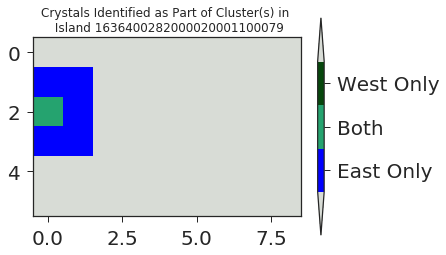

Unique island:  1636400282000020001100088
     Found Match ( 1001 1568 1 )
         East:  [12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0]
         West:  [33.0, 13.0, 22.0, 32.0]


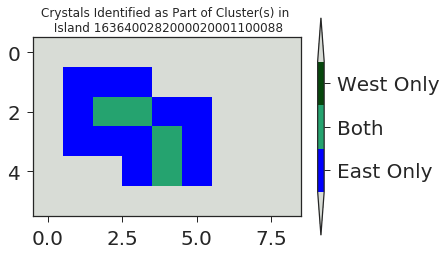

Unique island:  1636400282000020001100094
     Found Match ( 1002 1569 1 )
         East:  [13.0, 14.0, 15.0, 22.0, 23.0, 24.0, 31.0, 32.0, 33.0]
         West:  [23.0, 14.0, 22.0, 13.0]


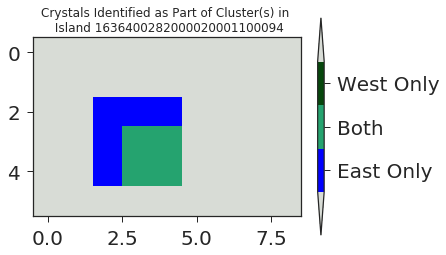

Unique island:  1636400282000020001100092
     Found Match ( 1003 1570 1 )
         East:  [7.0, 8.0, 16.0, 17.0, 25.0, 26.0]
         West:  [16.0, 17.0]


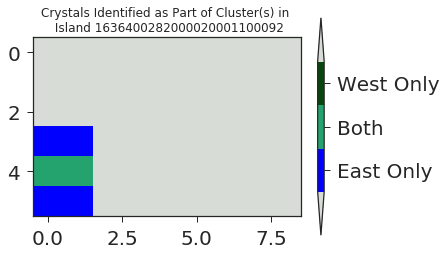

Unique island:  1636400282000020001100082
     Found Match ( 1004 1571 1 )
         East:  [18.0, 19.0, 27.0, 28.0, 36.0, 37.0]
         West:  [27.0, 18.0, 28.0]


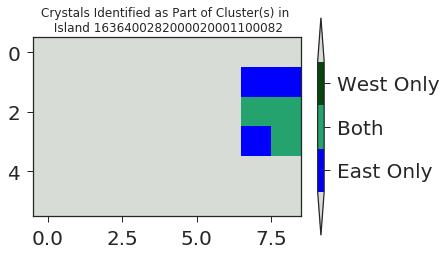

Unique island:  1636400282000020001100089
     Found Match ( 1005 1572 1 )
         East:  [22.0, 23.0, 24.0, 25.0, 26.0, 31.0, 32.0, 33.0, 34.0, 35.0, 40.0, 41.0, 42.0, 43.0, 44.0]
         West:  [34.0, 33.0, 32.0]


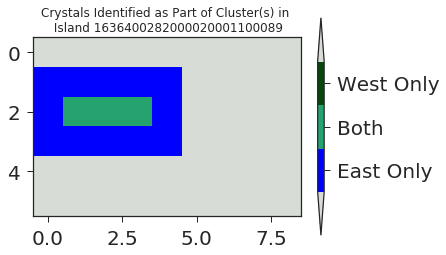

Unique island:  1636400282000020001100093
     Found another island with this unique ID. Adding their crystals together:
           [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0]
           [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 10.0, 11.0, 12.0, 19.0, 20.0, 21.0, 28.0, 29.0, 30.0]
     Found Match ( 1006 1573 1 )
         East:  [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 10.0, 11.0, 12.0, 19.0, 20.0, 21.0, 28.0, 29.0, 30.0]
         West:  [26.0, 34.0, 25.0, 19.0, 20.0, 33.0, 18.0, 27.0]


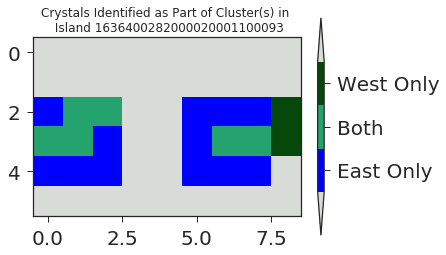

Unique island:  1636400282000020001100097
     Found Match ( 1008 1574 1 )
         East:  [5.0, 6.0, 7.0, 14.0, 15.0, 16.0, 23.0, 24.0, 25.0]
         West:  [6.0, 24.0, 15.0, 16.0]


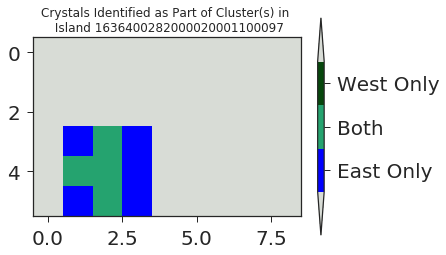

Unique island:  1636400282000020001100095
     Found Match ( 1009 1575 1 )
         East:  [25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
         West:  [34.0, 25.0, 35.0]


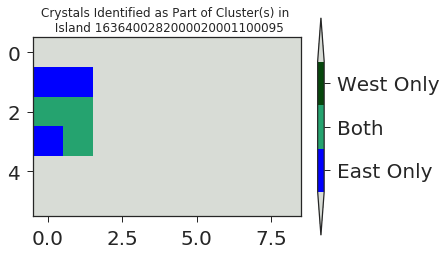

Unique island:  1636400282000020001100096
     Found Match ( 1010 1576 1 )
         East:  [6.0, 7.0, 8.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0]
         West:  [16.0, 15.0]


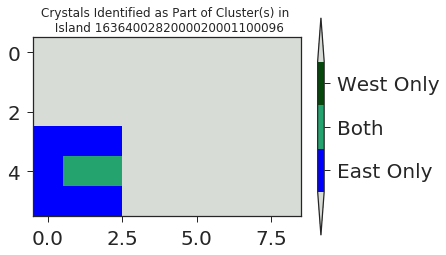

Unique island:  1636400282000020001100099
     Found Match ( 1011 1577 1 )
         East:  [2.0, 3.0, 4.0, 11.0, 12.0, 13.0, 20.0, 21.0, 22.0]
         West:  [23.0, 31.0, 16.0, 13.0, 12.0]


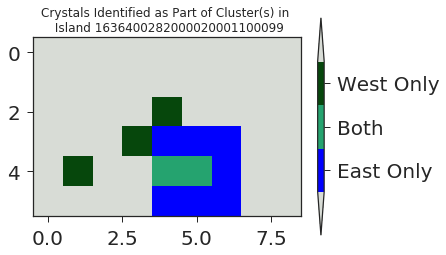

Unique island:  1636400282000020001100098
     Found Match ( 1012 1578 1 )
         East:  [6.0, 7.0, 8.0, 15.0, 16.0, 17.0]
         West:  [6.0, 7.0]


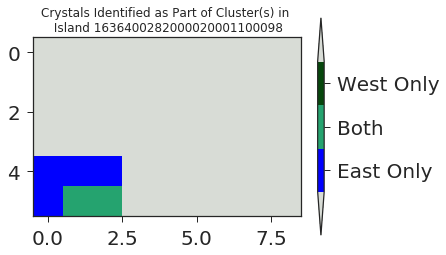

Unique island:  1636400282000020001100101
     Found Match ( 1013 1579 1 )
         East:  [24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 42.0, 43.0, 44.0]
         West:  [34.0, 35.0]


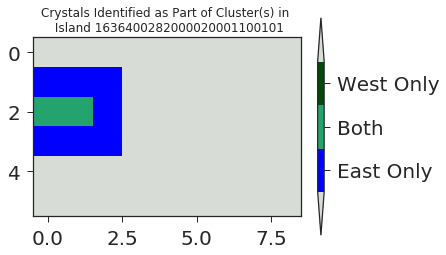

Unique island:  1636400282000020001100102
     Found Match ( 1014 1580 1 )
         East:  [16.0, 17.0, 25.0, 26.0, 34.0, 35.0]
         West:  [35.0, 25.0, 26.0, 34.0]


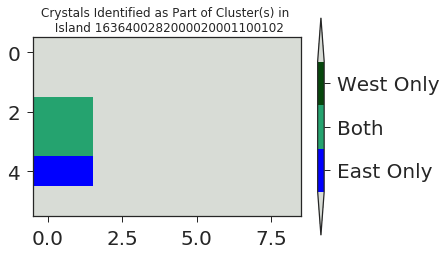

Unique island:  1636400282000020001100105
     Found Match ( 1015 1581 1 )
         East:  [20.0, 21.0, 22.0, 29.0, 30.0, 31.0, 38.0, 39.0, 40.0]
         West:  [39.0, 30.0, 29.0, 38.0]


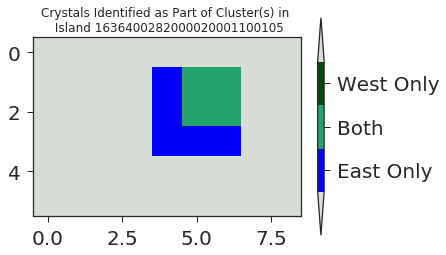

Unique island:  1636400282000020001100104
     Found Match ( 1016 1582 1 )
         East:  [0.0, 1.0, 2.0, 9.0, 10.0, 11.0, 18.0, 19.0, 20.0]
         West:  [1.0, 10.0, 9.0, 0.0]


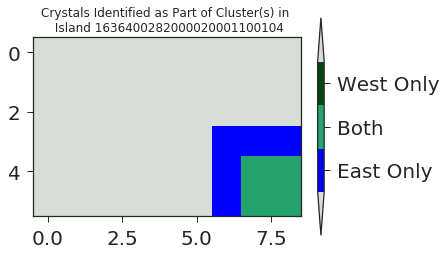

Unique island:  1636400282000020001100103
     Found Match ( 1017 1583 1 )
         East:  [24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 42.0, 43.0, 44.0]
         West:  [24.0, 34.0, 33.0]


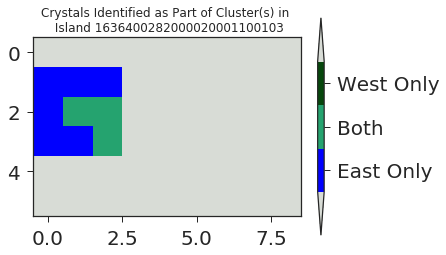

Unique island:  1636400282000020001100106
     Found Match ( 1018 1584 1 )
         East:  [38.0, 39.0, 40.0, 47.0, 48.0, 49.0]
         West:  [46.0, 48.0, 47.0, 49.0]


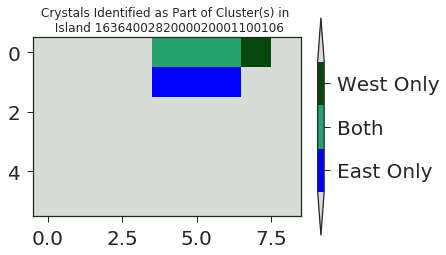

Unique island:  1636400282000020001100107
     Found Match ( 1019 1585 1 )
         East:  [7.0, 8.0, 16.0, 17.0, 25.0, 26.0]
         West:  [26.0, 17.0, 8.0, 16.0]


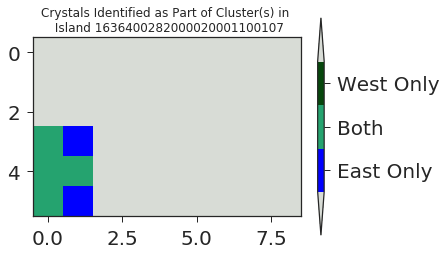

Unique island:  1636400282000020001100110
     Found Match ( 1020 1586 1 )
         East:  [30.0, 31.0, 32.0, 39.0, 40.0, 41.0, 48.0, 49.0, 50.0]
         West:  [41.0, 40.0, 49.0, 50.0, 31.0, 32.0]


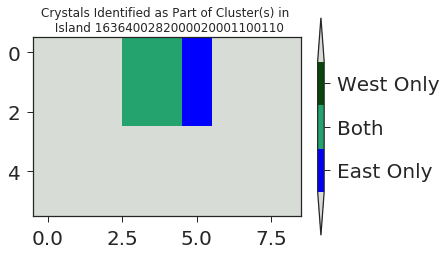

Unique island:  1636400282000020001100108
     Found Match ( 1021 1587 1 )
         East:  [5.0, 6.0, 7.0, 14.0, 15.0, 16.0, 23.0, 24.0, 25.0]
         West:  [14.0, 16.0, 15.0]


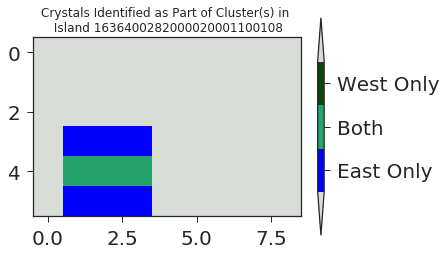

Unique island:  1636400282000020001100109
     Found Match ( 1022 1588 1 )
         East:  [0.0, 1.0, 9.0, 10.0]
         West:  [0.0]


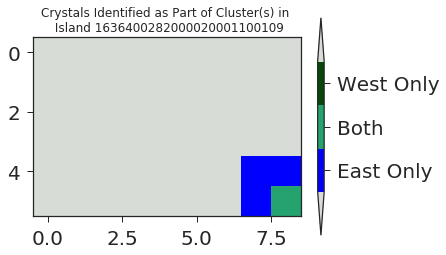

Unique island:  1636400282000020001100112
     Found Match ( 1023 1589 1 )
         East:  [25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
         West:  [33.0, 34.0, 35.0]


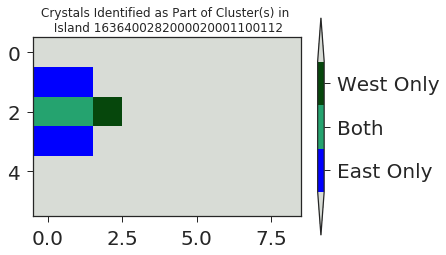

Unique island:  1636400282000020001100111
     Found Match ( 1024 1590 1 )
         East:  [25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
         West:  [35.0, 34.0]


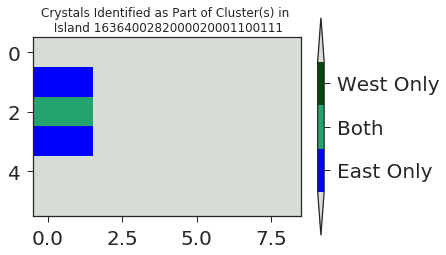

Unique island:  1636400282000020001200032
     Found Match ( 1025 1629 1 )
         East:  [23.0, 24.0, 25.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0]
         West:  [33.0, 24.0, 25.0, 34.0, 23.0]


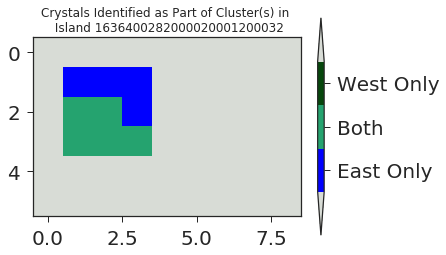

Unique island:  1636400282000020001200038
     Found Match ( 1026 1630 1 )
         East:  [9.0, 10.0, 18.0, 19.0, 27.0, 28.0]
         West:  [18.0]


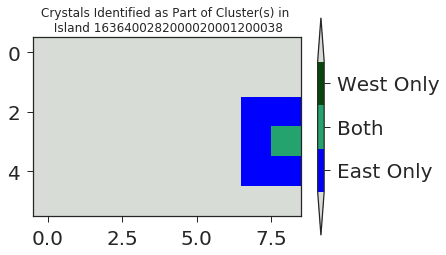

Unique island:  1636400282000020001200013
     Found Match ( 1027 1631 1 )
         East:  [0.0, 1.0, 9.0, 10.0, 18.0, 19.0]
         West:  [9.0]


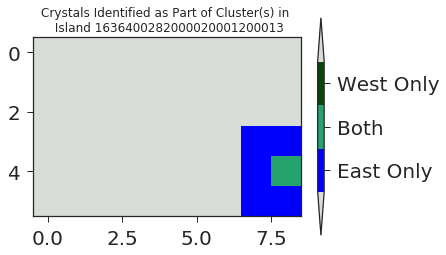

Unique island:  1636400282000020001200034
     Found Match ( 1028 1632 1 )
         East:  [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0]
         West:  [24.0, 16.0, 25.0]


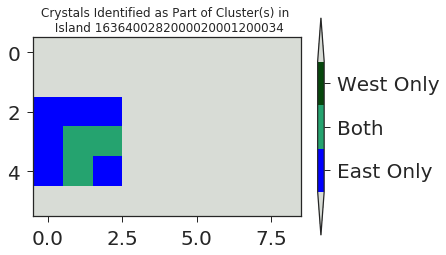

Unique island:  1636400282000020001200021
     Found Match ( 1029 1633 1 )
         East:  [10.0, 11.0, 12.0, 19.0, 20.0, 21.0, 28.0, 29.0, 30.0]
         West:  [20.0, 19.0, 18.0]


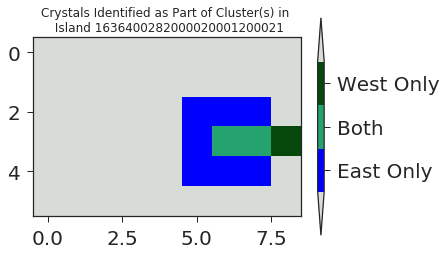

Unique island:  1636400282000020001200027
     Found Match ( 1030 1634 1 )
         East:  [16.0, 17.0, 25.0, 26.0, 34.0, 35.0]
         West:  [8.0, 17.0, 26.0, 25.0]


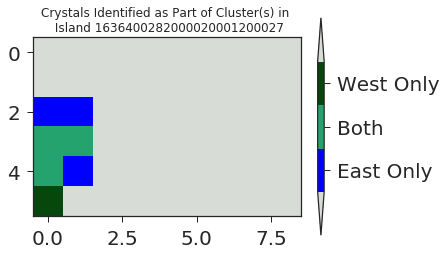

In [204]:
dingbefore = 0

for i, entry in enumerate(teast):
    
    if i < 1000:
        continue
    if i > 1030:
        break
    
    counter = 0
    ding = constructUniqueIDeast(entry)
    if (dingbefore == ding):
        continue
        
    print("Unique island: ", ding)
    
    crystalsEast = [x for x in entry.crystalsEast]
    for k, entry3 in enumerate(teast):
        if i != k:
            dong = constructUniqueIDeast(entry3)
            if ding == dong:
                print("     Found another island with this unique ID. Adding their crystals together:")
                print("          ",crystalsEast)
                crystalsEast += [x for x in entry3.crystalsEast]
                print("          ",crystalsEast)
    
    crystalsWest = []
    for j, entry2 in enumerate(twest):
        dong = constructUniqueIDwest(entry2)
        if (ding == dong):
            counter = counter + 1
            print("     Found Match (", i, j, counter,")")
            print("         East: ", crystalsEast)
            print("         West: ", [x for x in entry2.crystalsWest])
            crystalsWest += [x for x in entry2.crystalsWest]
            
    imshowCompare( toMap(crystalsEast), toMap(crystalsWest), True, ding)

        
    dingbefore = ding

In [97]:
vecX = []
for i, entry in enumerate(tcomp):
    if(r.TMath.Abs(entry.deltaX) > 4):
        print(constructUniqueID(entry))
        crystalsEast = entry.crystalsEast
        crystalsWest = entry.crystalsWest
        
        vecX.append( ([x for x in crystalsEast] , [x for x in crystalsWest]) )

1636400282000290000100186
1636400282000860000300180
1636400282000860002100118
1636400282001500002000161
1636400282001580000200103
1636400282001970000700162


In [33]:
print(len(vecX))
print(vecX)

50
[([9.0, 10.0, 11.0, 18.0, 19.0, 20.0, 27.0, 28.0, 29.0], [19.0, 20.0, 28.0]), ([9.0, 10.0, 11.0, 18.0, 19.0, 20.0, 27.0, 28.0, 29.0], [20.0, 19.0, 28.0, 10.0, 29.0, 18.0]), ([23.0, 24.0, 25.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0], [24.0, 33.0, 32.0, 42.0]), ([16.0, 17.0, 25.0, 26.0, 34.0, 35.0], [35.0, 34.0, 25.0, 26.0]), ([6.0, 7.0, 8.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0], [17.0, 24.0, 16.0, 7.0]), ([4.0, 5.0, 6.0, 13.0, 14.0, 15.0, 22.0, 23.0, 24.0], [24.0, 23.0, 13.0, 14.0, 15.0]), ([3.0, 4.0, 5.0, 12.0, 13.0, 14.0, 15.0, 16.0, 21.0, 22.0, 23.0, 24.0, 25.0, 32.0, 33.0, 34.0], [14.0, 13.0, 4.0, 24.0, 15.0, 25.0, 3.0]), ([31.0, 32.0, 33.0, 40.0, 41.0, 42.0, 49.0, 50.0, 51.0], [40.0, 50.0, 32.0, 41.0, 42.0]), ([33.0, 34.0, 35.0, 42.0, 43.0, 44.0, 51.0, 52.0, 53.0], [34.0, 25.0, 43.0, 35.0, 33.0]), ([15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0], [32.0, 16.0, 25.0, 24.0, 15.0]), ([15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0], [35.0, 34.0, 25.0, 16.0]), ([15.0, 16.0, 

([9.0, 10.0, 11.0, 18.0, 19.0, 20.0, 27.0, 28.0, 29.0], [19.0, 20.0, 28.0])


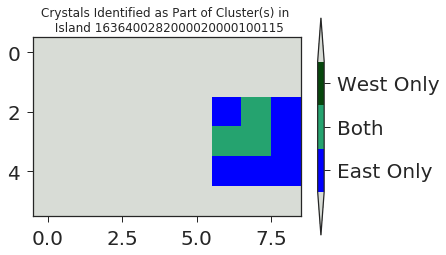

([9.0, 10.0, 11.0, 18.0, 19.0, 20.0, 27.0, 28.0, 29.0], [20.0, 19.0, 28.0, 10.0, 29.0, 18.0])


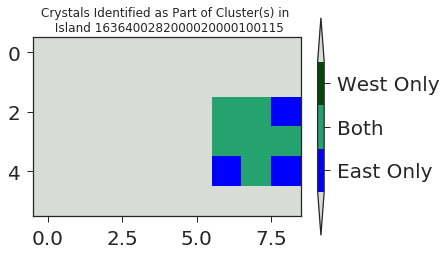

([23.0, 24.0, 25.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0], [24.0, 33.0, 32.0, 42.0])


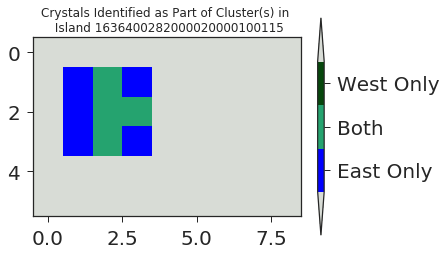

([16.0, 17.0, 25.0, 26.0, 34.0, 35.0], [35.0, 34.0, 25.0, 26.0])


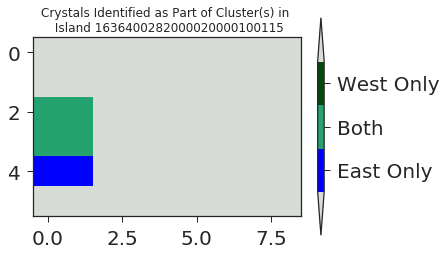

([6.0, 7.0, 8.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0], [17.0, 24.0, 16.0, 7.0])


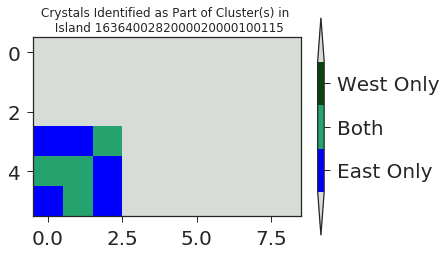

([4.0, 5.0, 6.0, 13.0, 14.0, 15.0, 22.0, 23.0, 24.0], [24.0, 23.0, 13.0, 14.0, 15.0])


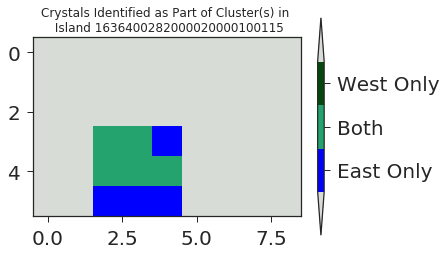

([3.0, 4.0, 5.0, 12.0, 13.0, 14.0, 15.0, 16.0, 21.0, 22.0, 23.0, 24.0, 25.0, 32.0, 33.0, 34.0], [14.0, 13.0, 4.0, 24.0, 15.0, 25.0, 3.0])


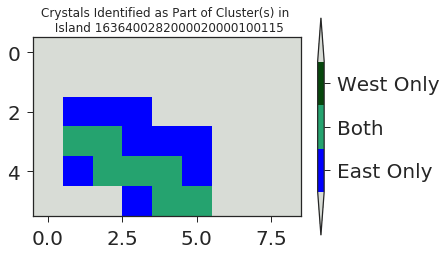

([31.0, 32.0, 33.0, 40.0, 41.0, 42.0, 49.0, 50.0, 51.0], [40.0, 50.0, 32.0, 41.0, 42.0])


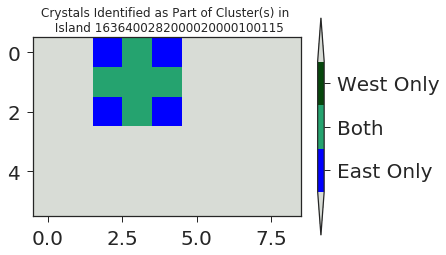

([33.0, 34.0, 35.0, 42.0, 43.0, 44.0, 51.0, 52.0, 53.0], [34.0, 25.0, 43.0, 35.0, 33.0])


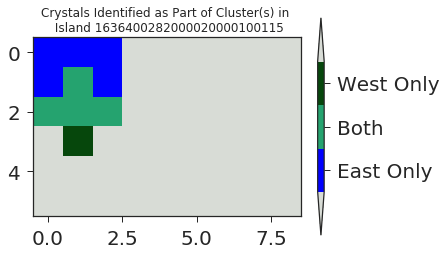

([15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0], [32.0, 16.0, 25.0, 24.0, 15.0])


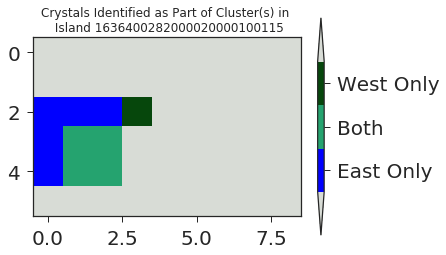

([15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0], [35.0, 34.0, 25.0, 16.0])


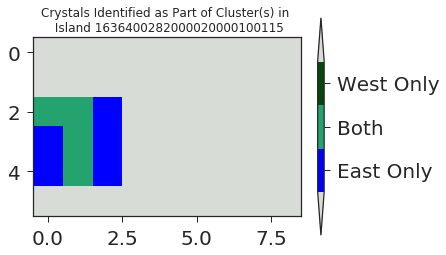

([15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0], [24.0, 33.0, 34.0, 25.0, 35.0, 26.0])


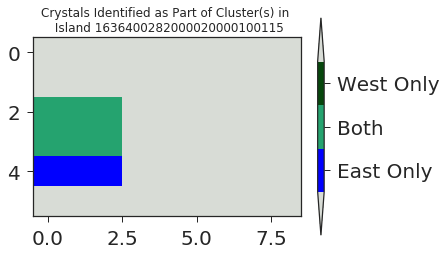

([34.0, 35.0, 43.0, 44.0, 52.0, 53.0], [34.0, 44.0, 35.0, 43.0, 25.0])


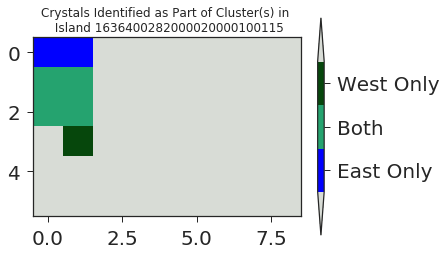

([9.0, 10.0, 11.0, 18.0, 19.0, 20.0, 27.0, 28.0, 29.0], [20.0, 9.0, 19.0, 28.0, 18.0])


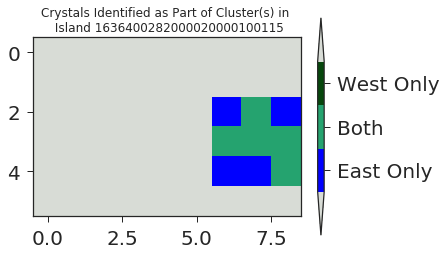

([9.0, 10.0, 11.0, 18.0, 19.0, 20.0, 27.0, 28.0, 29.0], [28.0, 19.0, 18.0, 20.0])


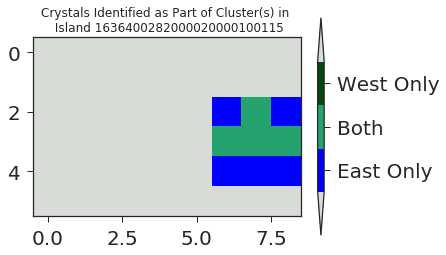

([15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0], [25.0, 33.0, 24.0, 15.0, 16.0])


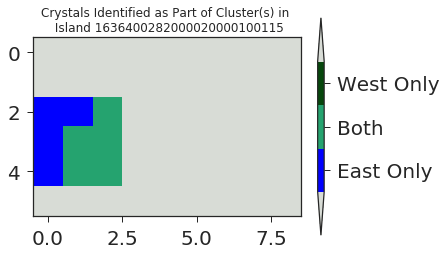

([33.0, 34.0, 35.0, 42.0, 43.0, 44.0, 51.0, 52.0, 53.0], [43.0, 53.0, 44.0, 42.0, 52.0])


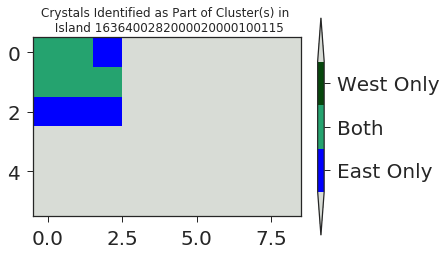

([15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0], [26.0, 16.0, 25.0])


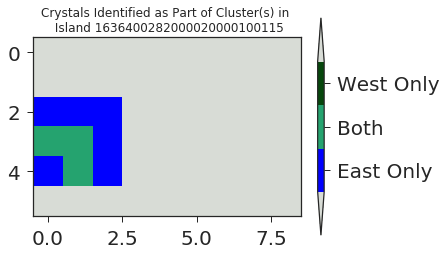

([6.0, 7.0, 8.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0], [7.0, 25.0, 16.0, 24.0, 15.0, 8.0, 17.0])


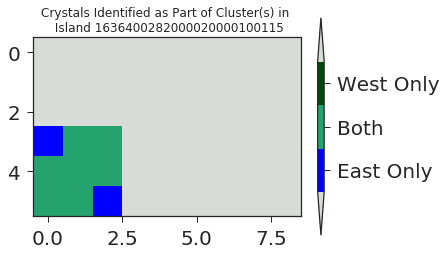

([4.0, 5.0, 6.0, 13.0, 14.0, 15.0, 22.0, 23.0, 24.0], [15.0, 23.0, 13.0, 14.0])


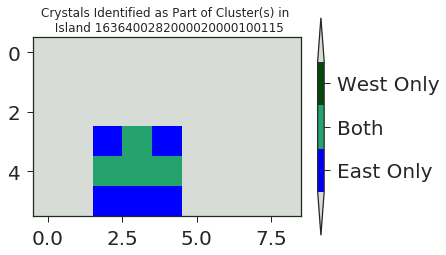

([16.0, 17.0, 25.0, 26.0, 34.0, 35.0], [26.0, 17.0, 25.0, 34.0])


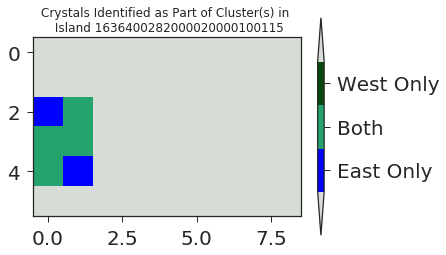

([12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0], [32.0, 31.0, 22.0, 21.0, 30.0, 24.0, 33.0, 42.0])


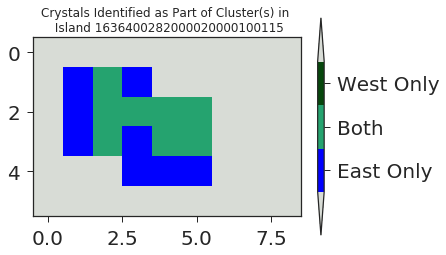

([23.0, 24.0, 25.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0], [41.0, 32.0, 24.0, 33.0, 23.0])


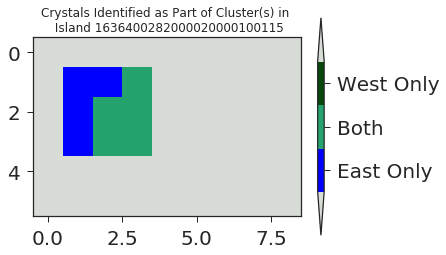

([33.0, 34.0, 35.0, 42.0, 43.0, 44.0, 51.0, 52.0, 53.0], [44.0, 34.0, 52.0, 43.0, 53.0, 42.0])


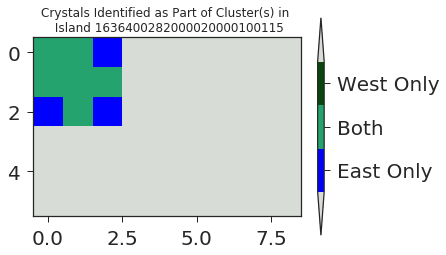

([32.0, 33.0, 34.0, 41.0, 42.0, 43.0, 50.0, 51.0, 52.0], [51.0, 42.0, 41.0, 43.0, 52.0])


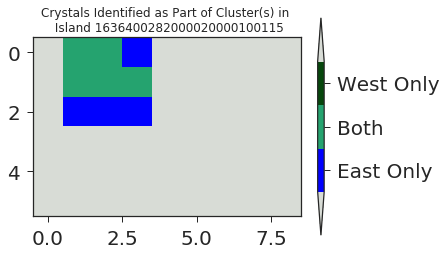

([24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 42.0, 43.0, 44.0], [25.0, 34.0, 33.0, 43.0, 35.0])


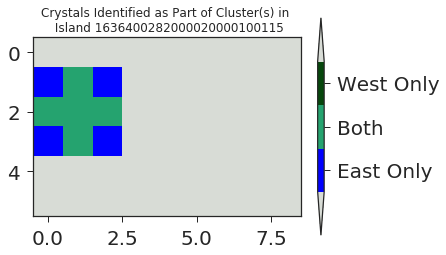

([33.0, 34.0, 35.0, 42.0, 43.0, 44.0, 51.0, 52.0, 53.0], [44.0, 52.0, 43.0, 53.0, 42.0])


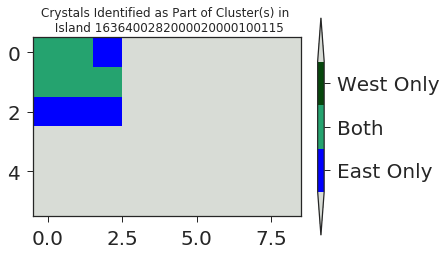

([7.0, 8.0, 16.0, 17.0, 25.0, 26.0], [26.0, 17.0, 16.0, 25.0])


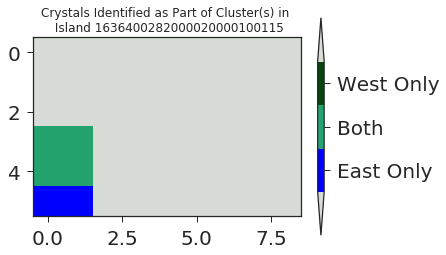

([15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0], [16.0, 24.0, 34.0, 25.0, 35.0])


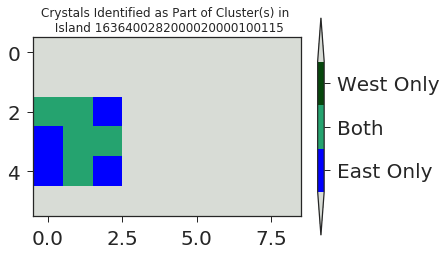

([15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0], [34.0, 25.0, 24.0, 26.0])


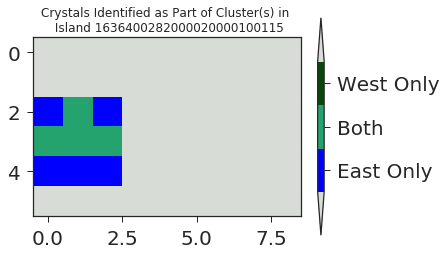

([31.0, 32.0, 33.0, 40.0, 41.0, 42.0, 49.0, 50.0, 51.0], [42.0, 41.0, 32.0, 40.0])


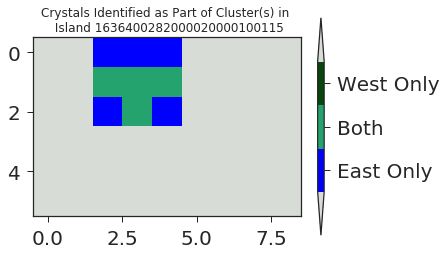

([23.0, 24.0, 25.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0], [24.0, 42.0, 33.0, 43.0, 34.0, 32.0])


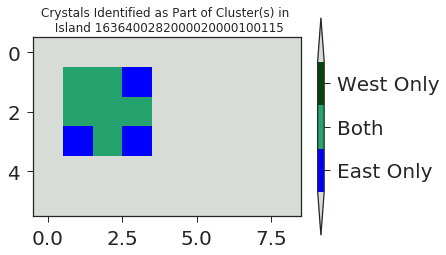

([5.0, 6.0, 7.0, 14.0, 15.0, 16.0, 23.0, 24.0, 25.0], [23.0, 15.0, 24.0, 14.0, 6.0])


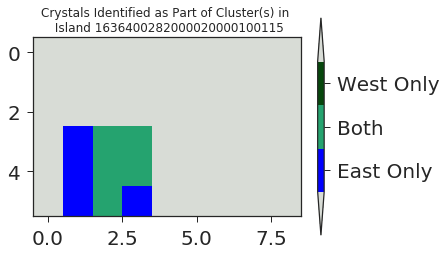

([4.0, 5.0, 6.0, 13.0, 14.0, 15.0, 22.0, 23.0, 24.0], [23.0, 14.0, 4.0, 13.0, 3.0, 5.0])


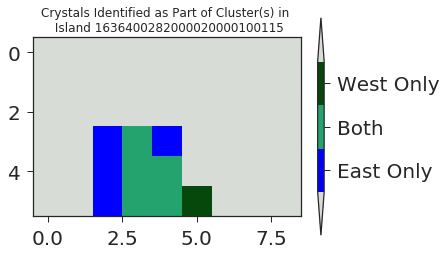

([23.0, 24.0, 25.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0], [42.0, 33.0, 32.0])


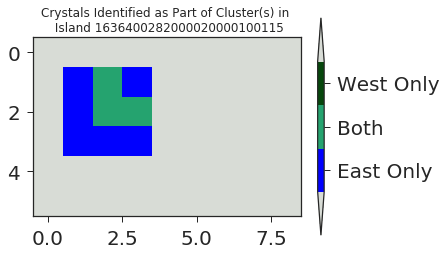

([23.0, 24.0, 25.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0], [23.0, 42.0, 32.0, 33.0, 24.0, 41.0, 31.0])


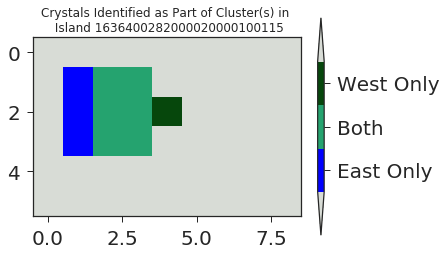

([23.0, 24.0, 25.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0], [50.0, 42.0, 33.0, 32.0, 41.0])


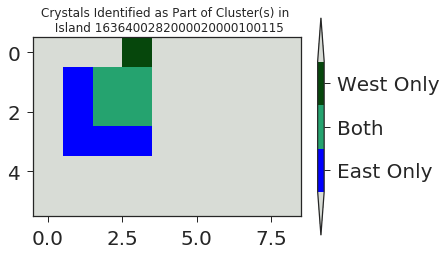

([32.0, 33.0, 34.0, 41.0, 42.0, 43.0, 50.0, 51.0, 52.0], [41.0, 42.0, 51.0, 33.0])


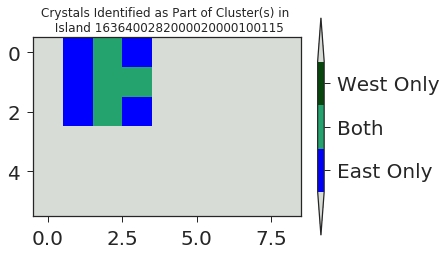

([32.0, 33.0, 34.0, 41.0, 42.0, 43.0, 50.0, 51.0, 52.0], [41.0, 51.0, 43.0, 42.0, 52.0])


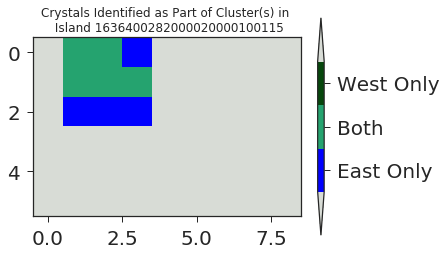

([23.0, 24.0, 25.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0], [42.0, 24.0, 33.0, 34.0, 32.0, 23.0])


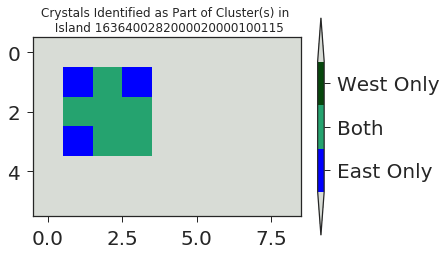

([24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 42.0, 43.0, 44.0], [35.0, 33.0, 34.0, 43.0])


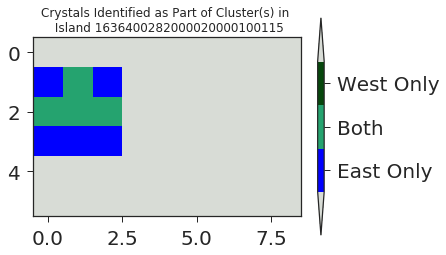

([6.0, 7.0, 8.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0], [25.0, 17.0, 16.0])


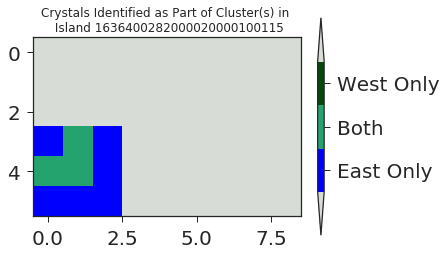

([9.0, 10.0, 11.0, 18.0, 19.0, 20.0, 27.0, 28.0, 29.0], [18.0, 19.0, 10.0, 9.0])


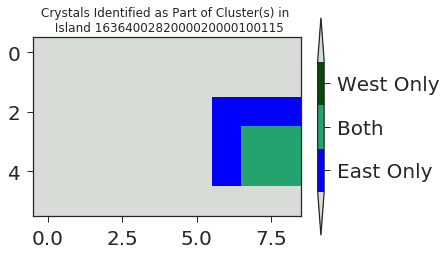

([31.0, 32.0, 33.0, 40.0, 41.0, 42.0, 49.0, 50.0, 51.0], [41.0, 50.0, 32.0, 40.0])


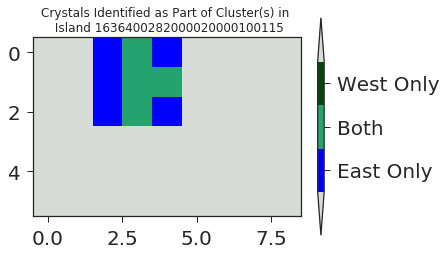

([33.0, 34.0, 35.0, 42.0, 43.0, 44.0, 51.0, 52.0, 53.0], [35.0, 44.0, 43.0, 34.0, 52.0])


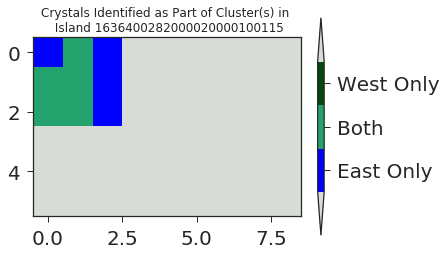

([15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 42.0, 43.0, 44.0], [26.0, 17.0, 25.0, 16.0, 42.0, 33.0, 43.0, 35.0, 34.0])


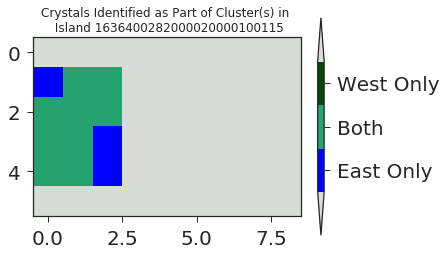

([29.0, 30.0, 31.0, 38.0, 39.0, 40.0, 47.0, 48.0, 49.0], [31.0, 49.0, 30.0, 40.0, 38.0, 39.0, 48.0])


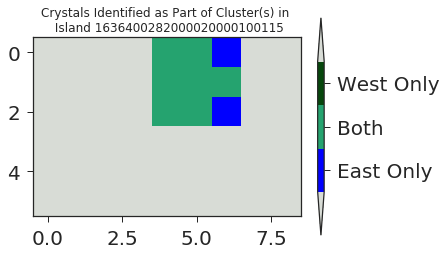

([33.0, 34.0, 35.0, 42.0, 43.0, 44.0, 51.0, 52.0, 53.0], [43.0, 52.0, 34.0, 42.0])


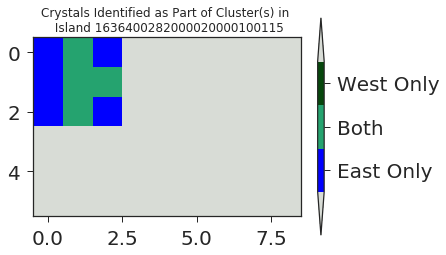

([33.0, 34.0, 35.0, 42.0, 43.0, 44.0, 51.0, 52.0, 53.0], [16.0, 42.0, 52.0, 53.0, 35.0, 44.0, 43.0, 34.0])


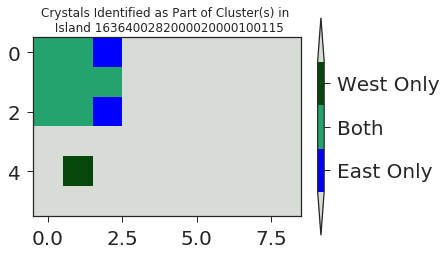

([23.0, 24.0, 25.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0], [34.0, 42.0, 43.0, 33.0])


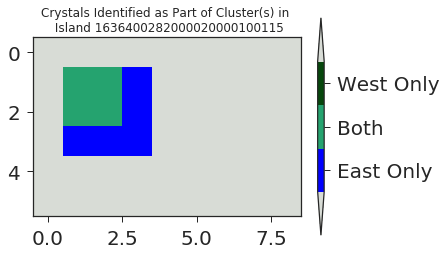

In [34]:
for entry in vecX:
    print(entry)
    cw = entry[1]
    ce = entry[0]
    
    imshowCompare( toMap(ce), toMap(cw), True, ding)

In [37]:
twave.Print()

******************************************************************************
*Tree    :islandTree: Tree of xtal traces                                    *
*Entries :   361835 : Total =      1581232339 bytes  File  Size =  670757077 *
*        :          : Tree compression factor =   2.36                       *
******************************************************************************
*Br    0 :xtal0     : vector<short>                                          *
*Entries :   361835 : Total  Size=   29070387 bytes  File Size  =   12054494 *
*Baskets :      157 : Basket Size=    1394688 bytes  Compression=   2.41     *
*............................................................................*
*Br    1 :xtal1     : vector<short>                                          *
*Entries :   361835 : Total  Size=   29070387 bytes  File Size  =   12179864 *
*Baskets :      157 : Basket Size=    1394688 bytes  Compression=   2.39     *
*...................................................

In [207]:
def islandPlot(uniqueIDref, saveImage = True):
    counter = 0
    
    crystalsEast = []
    for k, entry3 in enumerate(teast):
        dong = constructUniqueIDeast(entry3)
        if uniqueIDref == dong:
            crystalsEast += [x for x in entry3.crystalsEast]
                
    mapEast = toMap(crystalsEast)
    print("East: ", mapEast)
    
    crystalsWest = []
    for j, entry2 in enumerate(twest):
        dong = constructUniqueIDwest(entry2)
        if (uniqueIDref == dong):
            crystalsWest += [x for x in entry2.crystalsWest]

    mapWest = toMap(crystalsWest)
    print("West: ", mapWest)


    for i,entry in enumerate(twave):
        if( constructUniqueIDwave(entry) == uniqueIDref ):
            if counter > 3:
                break
            counter = counter + 1

            fig, axarr = plt.subplots(6,9, sharey=True, sharex=True,figsize=(15, 10))
            print("Entry #", i+1)
            plotVec = []
            for crystal in range(0,54):
                branchString = "twave.xtal"+str(crystal)
                entryVeci = []
                rootVec = eval(branchString)# t.xtal53
                length = rootVec.size()
                for ding in range(length):
                    entryVeci.append( rootVec[ding] )
                plotVec.append(entryVeci)

            plotVec.reverse()
            list1 = []
            list2 = []
            xtal = []
            list2xtal = []
            for crystal in range(54):
                list2.append(plotVec[crystal]) 
                list2xtal.append(crystal)
                if (crystal+1) % 9 == 0: #split into 9 column blocks
                    list1.append(list2)
                    list2 = []
                    list2xtal.reverse()
                    xtal.append(list2xtal)
                    list2xtal = []
            xtal.reverse()


            aboveThresholdVec = []
            for ding in range(9):
                for j in range(6):
                    if(len(list1[j][ding]) < 1):
                        axarr[j,ding].plot(list1[j][ding],color='g') 
                    elif(np.abs( np.mean((list1[j][ding])[0:6]) - np.max(list1[j][ding]) ) > 60): #global threshold = 60
                        axarr[j,ding].plot(list1[j][ding],color='r') 
                        aboveThresholdVec.append( (j, ding) )
                    else:
                        axarr[j,ding].plot(list1[j][ding],color='black') 
                    axarr[j,ding].set_title(str(xtal[j][ding]),y = 0.95)


            #grey out all of the +3x3 grid
            xtalsVec = []
            for xtal in aboveThresholdVec:
                for nxtals in ReturnNeighbors_4(xtal[1],xtal[0]):
                    axarr[nxtals[1],nxtals[0]].set_facecolor('xkcd:light grey')
                    xtalsVec.append(nxtals)
                xtalsVec.append((xtal[1],xtal[0]))

            plt.suptitle("Unpacked Islands from Calo "+str(twave.caloNum)
                         +" [run "+str(twave.runNum)+", subRun "+str(twave.subRunNum)
                         +", fill "+str(twave.fillNum)+", island "+str(twave.islandNum)+"]"
                         ,y = 0.93, fontsize=20)
            

            #now lets color them ala the plots above
            for ding in range(9):
                for j in range(6):
                    in3x3check = False
                    if((mapWest[j][ding] == 1) and (mapEast[j][ding] == 1)):
                        axarr[j,ding].set_facecolor('xkcd:teal green')
                        in3x3check = True
                    elif(mapWest[j][ding] == 1):
                        axarr[j,ding].set_facecolor('xkcd:forest green')
                        in3x3check = True
                    elif(mapEast[j][ding] == 1):
                        axarr[j,ding].set_facecolor('xkcd:cerulean')
                        in3x3check = True
                      
                    #make the borders red if this xtal is not within the 3x3 grid that would be saved
                    if( (ding,j) not in xtalsVec and in3x3check):
                        #axarr[j,ding].set_facecolor('xkcd:lilac')
                        axarr[j,ding].spines['right'].set_color('xkcd:neon purple')
                        axarr[j,ding].spines['left'].set_color('xkcd:neon purple')
                        axarr[j,ding].spines['top'].set_color('xkcd:neon purple')
                        axarr[j,ding].spines['bottom'].set_color('xkcd:neon purple')
                        axarr[j,ding].title.set_color('xkcd:neon purple')
                        axarr[j,ding].spines['right'].set_linewidth(3)
                        axarr[j,ding].spines['left'].set_linewidth(3)
                        axarr[j,ding].spines['top'].set_linewidth(3)
                        axarr[j,ding].spines['bottom'].set_linewidth(3)
                        
            #create custom lines for the legend with the same colors as above
            from matplotlib.lines import Line2D
            custom_lines = [Line2D([0], [0], color='xkcd:forest green', lw=4),
                            Line2D([0], [0], color='xkcd:teal green', lw=4),
                            Line2D([0], [0], color='xkcd:cerulean', lw=4),
                            Line2D([0], [0], color='xkcd:light grey', lw=4),
                            Line2D([0], [0], color='r', lw=4),
                            Line2D([0], [0], color='xkcd:neon purple', lw=4)]

            fig.legend(custom_lines,
                       ('Recon West Only', 'Shared', 'Recon East Only', 
                        'in 3x3 Grid', 'Above Threshold', 'In a Cluster, but\n not in 3x3 Grid'),
                       'upper right')

            if(saveImage):
                plt.savefig("./images/UnpackedIslands_CT_calo"+str(twave.caloNum).zfill(2)+"_run"+str(twave.runNum)+"_subRun"
                            +str(twave.subRunNum).zfill(5)+"_entry"+str(i)+".png",bbox_inches='tight')
            plt.show()

            break

East:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
West:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Entry # 1243


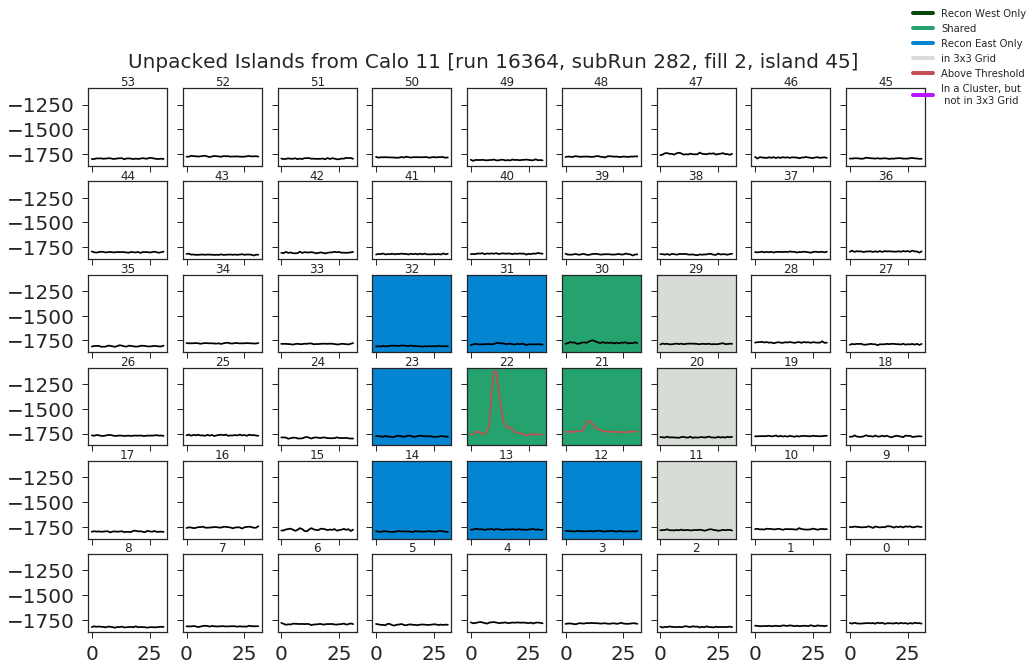

In [211]:
uniqueIDref = 1636400282000020001100045
islandPlot(uniqueIDref, saveImage = True)

1636400282000390000800136 ( 1 )
East:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0]]
West:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0]]
Entry # 57958


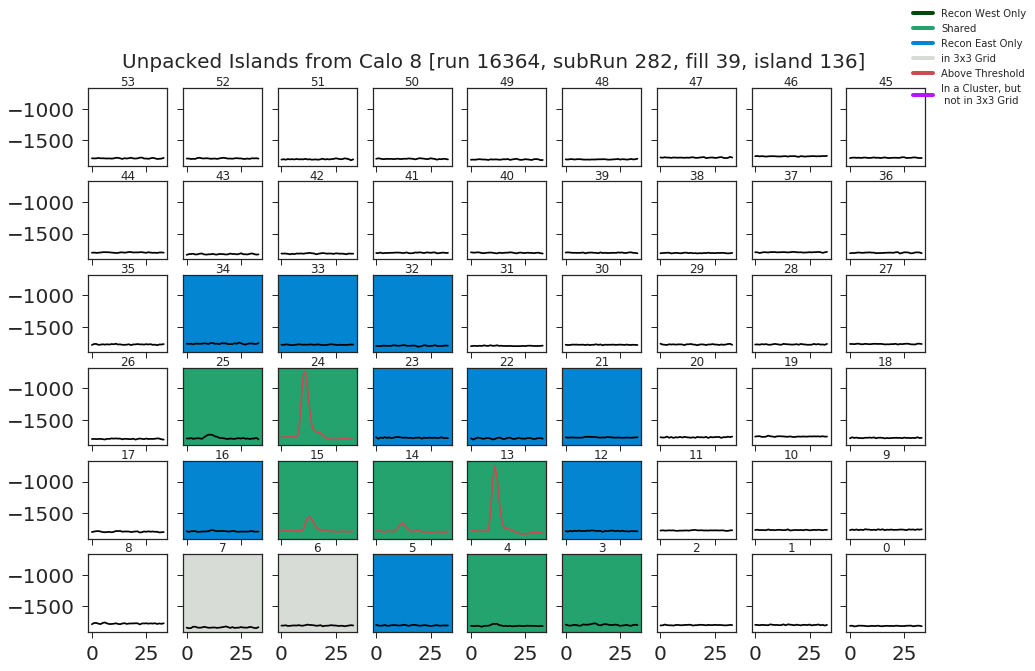

1636400282000440000800172 ( 2 )
East:  [[0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
West:  [[0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Entry # 64698


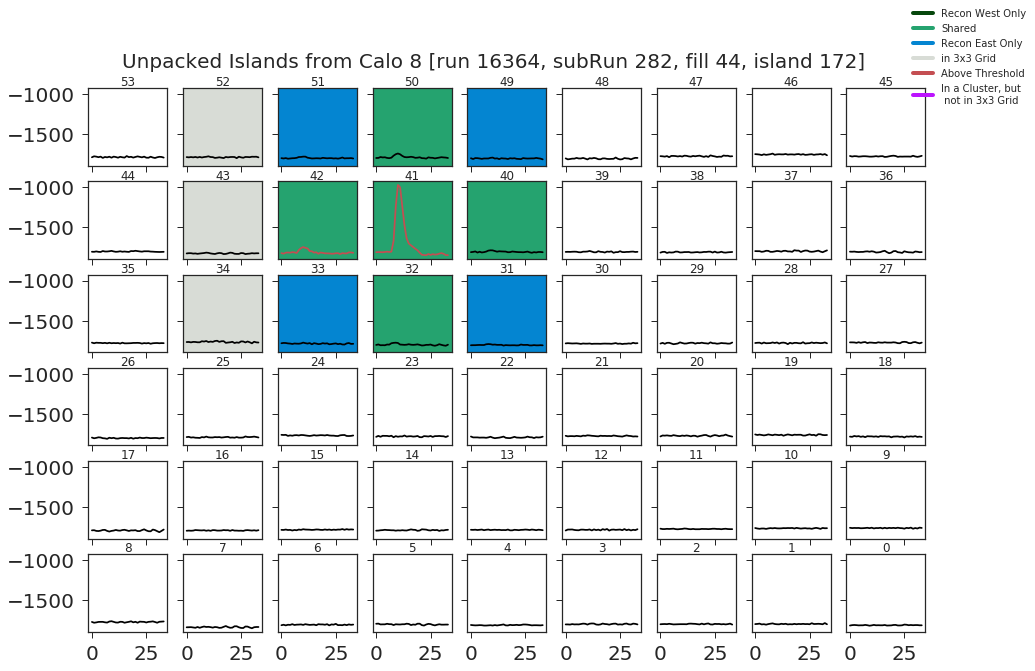

1636400282000560000600117 ( 3 )
East:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
West:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Entry # 89009


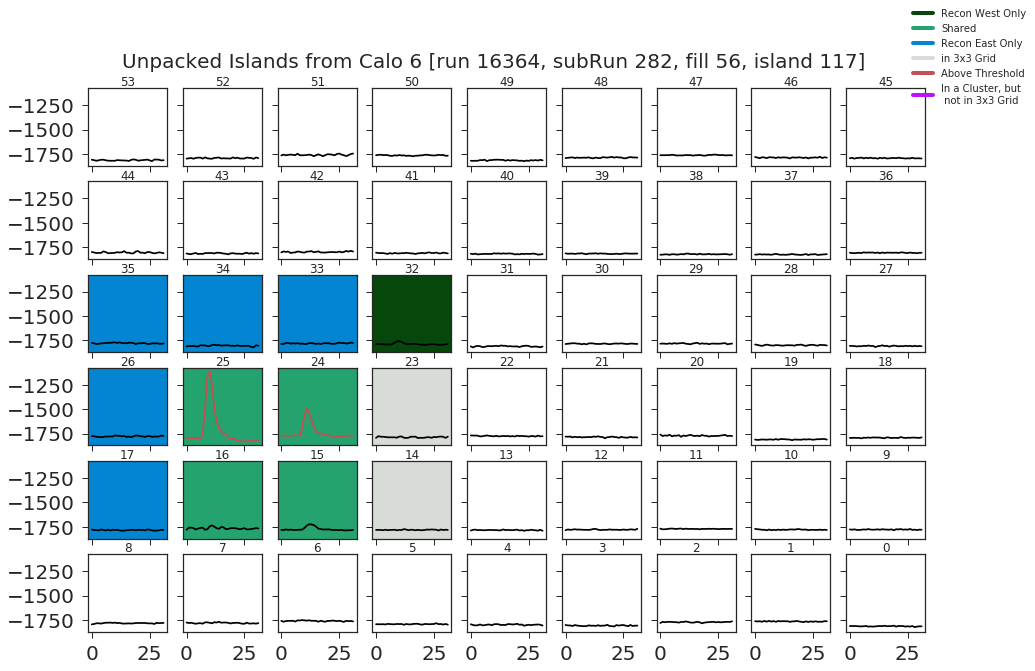

1636400282000690001100158 ( 4 )
East:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
West:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Entry # 111966


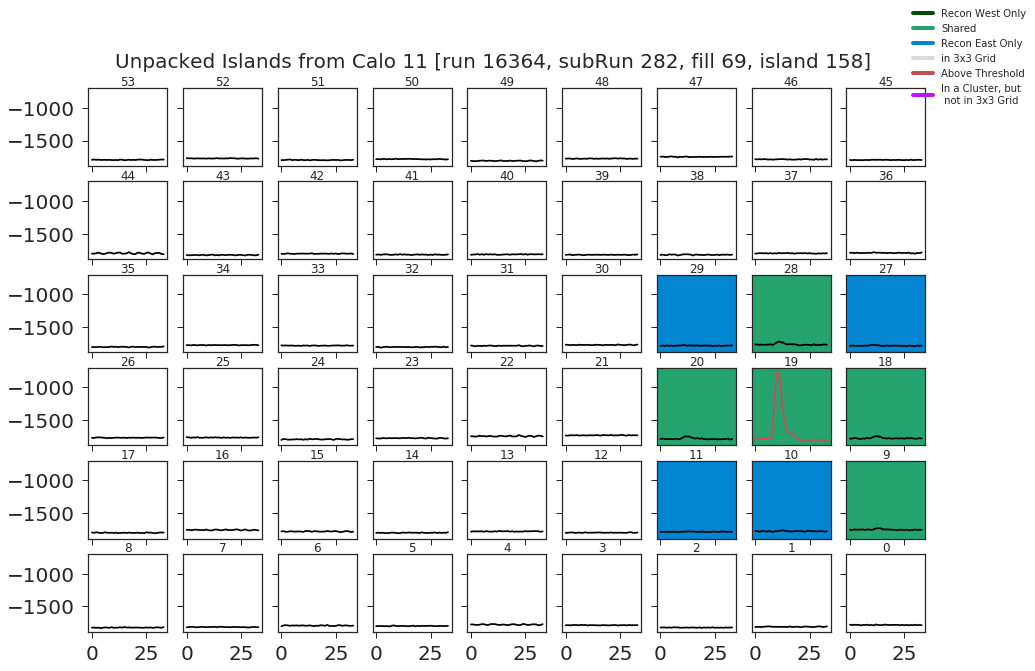

1636400282000730001100144 ( 5 )
East:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
West:  [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Entry # 119395


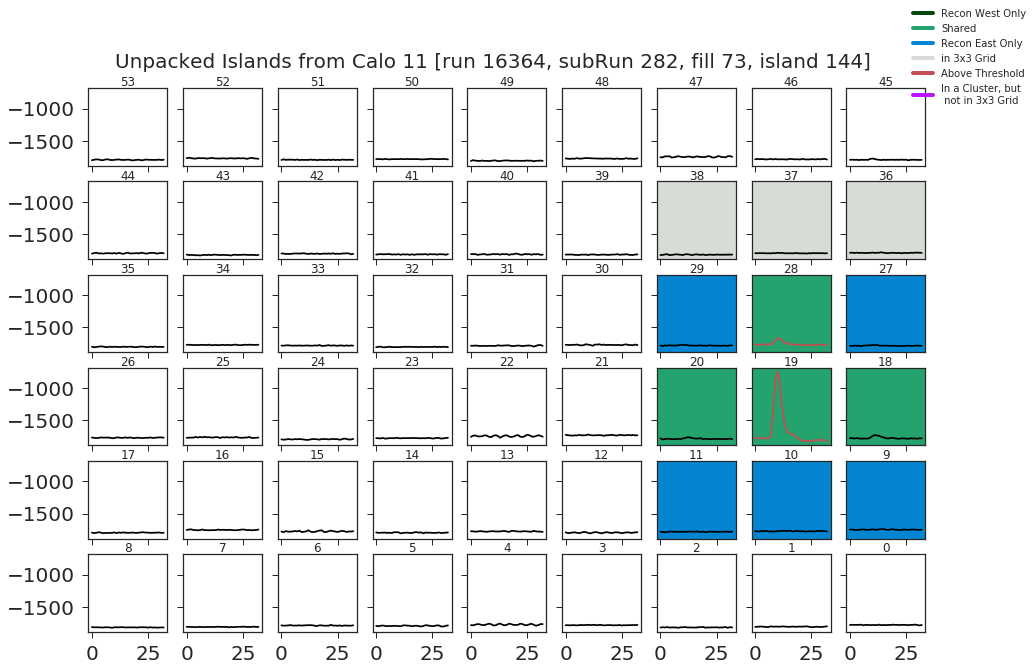

In [206]:
counter = 0
for i, entry in enumerate(tcomp):
    if(r.TMath.Abs(entry.deltaE) > 1700 ):
        counter += 1
        if counter > 5:
            break
        print(constructUniqueID(entry), "(",counter,")")
        islandPlot(constructUniqueID(entry), True)